In [28]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='15cfd96b0bdfd1b0c67597c24f91907776c02a6d', drake_version='0.27.0', drake_build='release')

server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']
# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc_planar, zmq_url_planar, web_url_planar = start_zmq_server_as_subprocess(server_args=server_args)
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

import numpy as np
from ipywidgets import FloatSlider, ToggleButton
from IPython.display import display, SVG, HTML
import pydot

import pydrake.all
from pydrake.all import (
    MultibodyPlant, DiagramBuilder, LinearQuadraticRegulator, Saturation, SceneGraph, Simulator, 
    WrapToSystem, AddMultibodyPlantSceneGraph, Parser, MathematicalProgram, eq, PiecewisePolynomial,
    SnoptSolver, TrajectorySource, MultibodyPositionToGeometryPose, PlanarSceneGraphVisualizer
)
from pydrake.examples.acrobot import AcrobotPlant, AcrobotGeometry
from pydrake.systems.jupyter_widgets import WidgetSystem
from pydrake.common.containers import namedview
from underactuated import FindResource
from underactuated.jupyter import running_as_notebook
import matplotlib.pyplot as plt


Notebook Goals:

*   Function to evaluate integrated cost (ie. total cost it took to get there), can break up by state (away from target state) and actuation state -> quad cost function
*   Function to evaluate and graph time to steady state (ie. settling time)
*   Function to evaluate and graph overshoot (both types, in x and in theta)
*   Function to evaluate and graph average tilt angle



Inputs to each function:

$q[t]$ - the state ($x, \theta$) for each $t$

$u[t]$ - the actuation input ($u_x, u_\theta$) for each $t$

goal - the goal state ($x_{tf}, \theta_{tf}$)

$T$ - the total time

In [29]:
def integrated_cost(q, u, goal, T):
  total_distance_from_target = 0
  total_actuation = 0
  goal_x = goal[0]

  for t in range(len(q)):
    cur_x = q[t][0]
    distance = (cur_x**2 + goal_x**2)**0.5
    total_distance_from_target += distance

    total_actuation += u[t][0]  # assuming u_x = u_theta since that's what Jorge said

  return total_distance_from_target/len(q), total_actuation/len(q)


In [34]:
def cost_breakdown(q, u, goal, T, display=False, yscale="linear"):
  total_distance_from_target = 0
  total_actuation = 0
  goal_x = goal[0]

  distance_from_target = np.array([(q[t][0]**2 + goal_x**2)**0.5 for t in range(len(q))])
  actuation = np.array([u[t][0] for t in range(len(q))])  # assuming u_x = u_theta since that's what Jorge said

  distance_squared = distance_from_target**2
  actuation_squared = actuation**2
  cost = distance_squared + actuation_squared
  total_cost = np.sum(cost)

  if display:
    cost_sum = np.zeros(cost.shape)
    total = 0
    for i in range(cost.shape[0]):
      total += cost[i]
      cost_sum[i] = total

    time_steps = len(q)
    increment = T/time_steps
    times = [t*increment for t in range (len(q))]
    plt.plot(times, distance_from_target, label="Distance From Target")
    plt.plot(times, actuation, label="Actuation")
    plt.plot(times, cost, label="Cost")
    plt.plot(times, cost_sum, label="Total Cost")
    plt.yscale(yscale)
    plt.legend()
    plt.show()

  return distance_from_target, actuation, cost, total_cost

In [3]:
def settling_time(q, u, goal, T):
  """ Return None if never settled """
  settling_time = None
  goal_x = goal[0]

  for t in range(len(q) - 1, -1, -1):
    cur_x = q[t][0]
    if cur_x != goal_x:
      settling_time = t + 1
      break

  if q[-1][0] != goal[0]:
    return None

  time_steps = len(q)
  increment = T/time_steps
  settling_time *= increment
  return settling_time

In [4]:
def overshoot(q, u, goal, T, display=False):
  """ Return None if never reached goal """
  settling_time = None
  goal_x = goal[0]
  start_x = q[0][0]
  timestep_reached_goal = None

  if start_x < goal_x:
    for t in range(len(q)):
      cur_x = q[t][0]
      if cur_x >= goal_x:
        timestep_reached_goal = t  # overestimate if not exactly equal
        break
  else:
    for t in range(len(q)):
      cur_x = q[t][0]
      if cur_x <= goal_x:
        timestep_reached_goal = t  # overestimate if not exactly equal
        break

  total_overshoot = 0
  for t in range(timestep_reached_goal, len(q), -1):
    cur_x = q[t][0]
    total_overshoot += abs(goal_x - cur_x)

  if display:
    # here, I'll plot the distance from goal as a function of time
    xs = np.array([q[t][0] for t in range (len(q))])
    distances = xs - goal_x
    time_steps = len(q)
    increment = T/time_steps
    times = [t*increment for t in range (len(q))]
    plt.plot(times, distances)
    plt.show()

  return total_overshoot/len(q)

In [5]:
def tilt_angle(q, u, goal, T, display=False):
  """ Return None if never reached goal """
  tilt_angles = np.array([q[t][1] for t in range(len(q))])
  tilt_from_goal = tilt_angles - goal[1]

  if display:
    # here, I'll plot the tilt angle from goal as a function of time
    time_steps = len(q)
    increment = T/time_steps
    times = [t*increment for t in range (len(q))]
    plt.plot(times, tilt_angles, label="tilt angle")
    plt.plot(times, tilt_from_goal, label="tilt angle from target")
    plt.show()

  return np.mean(tilt_angles)

## Graphing

In [37]:
# example trajectories
goal = [0,0]
T = 20
u1 = np.random.rand(T, 2)
q1 = np.array([[t/10, .2] for t in range(T//2, 0, -1)] + [[t/10 - (T//2)/10, .1] for t in range(T//2, T)])
u2 = np.random.rand(T, 2)
q2 = np.array([[t/20, .2] for t in range(T//2, 0, -1)] + [[t/10 - (T//2)/20, .1] for t in range(T//2, T)])

Take in many trajectories and compare costs/how they accumulate costs over time

In [38]:
integrated_cost(q1, u1, goal, T)

(0.5, 0.4050585117883855)

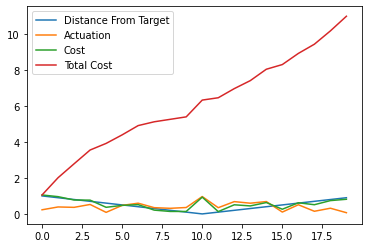

(array([1. , 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0. , 0.1, 0.2,
        0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 array([0.22952938, 0.38685002, 0.36526071, 0.52533148, 0.08650554,
        0.47392752, 0.59628794, 0.34786637, 0.31174962, 0.35620442,
        0.96567429, 0.34597882, 0.68369625, 0.59548789, 0.68735228,
        0.10285801, 0.50902662, 0.14710447, 0.31615687, 0.06832175]),
 array([1.05268374, 0.95965293, 0.77341538, 0.76597316, 0.36748321,
        0.4746073 , 0.5155593 , 0.21101101, 0.13718782, 0.13688159,
        0.93252684, 0.12970134, 0.50744056, 0.44460583, 0.63245315,
        0.26057977, 0.6191081 , 0.51163972, 0.73995517, 0.81466786]),
 10.9871337980047)

In [39]:
cost_breakdown(q1, u1, goal, T, display=True, yscale="linear")

In [67]:
def graph_cost_breakdowns(q, u, goal, T, cost_type, controller_labels=None):
  """ Inputs q, u are of shape (num_traj, num_time_steps, 2) """
  distances = np.zeros(q.shape[:2])
  actuations = np.zeros(q.shape[:2])
  costs = np.zeros(q.shape[:2])

  for i in range(len(q)):
    traj = q[i]
    actuation = u[i]
    distances[i, :], actuations[i, :], costs[i, :], total_cost = cost_breakdown(traj, actuation, goal, T)

  time_steps = len(q)
  increment = T/time_steps
  times = [t*increment for t in range (q.shape[1])]

  if controller_labels is None:
    controller_labels = ["" for i in range(q.shape[0])]
    labels = False 
  else:
    labels = True

  for i in range(q.shape[0]):
    if cost_type == "Distance":
      plt.plot(times, distances[i], label=controller_labels[i])
    elif cost_type == "Distance squared":
      plt.plot(times, distances[i]**2, label=controller_labels[i])
    elif cost_type == "Actuation":
      plt.plot(times, actuations[i], label=controller_labels[i])
    elif cost_type == "Actuation squared":
      plt.plot(times, actuations[i]**2, label=controller_labels[i])
    elif cost_type == "Cost":
      plt.plot(times, costs[i], label=controller_labels[i])
    else:
      print("cost_type not supported")

  if labels:
    plt.legend()
  plt.title(cost_type)
  plt.show()


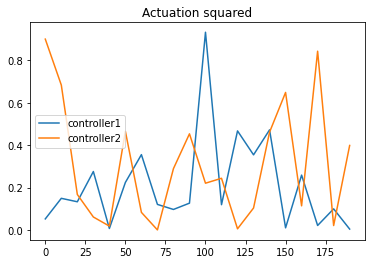

In [66]:
graph_cost_breakdowns(np.array([q1, q2]), np.array([u1, u2]), goal, T, "Actuation squared", controller_labels=["controller1", "controller2"])